In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

plt.rcParams["font.family"] = "serif"

In [2]:
def compute_coverage_probs(true_values, ci_lower, ci_upper):
    """Compute empirical coverage probabilities.
    
    Args:
        true_values: Ground truth values, shape (n_samples,)
        ci_lower: Lower bounds of credible intervals, shape (n_samples, n_confidence_levels)
        ci_upper: Upper bounds of credible intervals, shape (n_samples, n_confidence_levels)
    
    Returns:
        Coverage probabilities for each confidence level, shape (n_confidence_levels,)
    """
    coverage = (ci_lower <= true_values.unsqueeze(-1)) * (true_values.unsqueeze(-1) <= ci_upper)
    return coverage.float().mean(0)

In [3]:
def plot_coverage_probs(confidence_levels, shear1_coverage_probs, shear2_coverage_probs, save_path=None):
    """Plot nominal vs empirical coverage probabilities.
    
    Args:
        confidence_levels: Nominal confidence levels
        shear1_coverage_probs: Empirical coverage for shear1
        shear2_coverage_probs: Empirical coverage for shear2
        save_path: Optional path to save the figure
    """
    fig, ax = plt.subplots(1, 2, figsize=(7, 3))
    fontsize = 14
    ticklabelsize = 8
    color = "#1c692b"
    s = 40

    _ = ax[0].axline((0, 0), slope=1, linestyle="dotted", color="black", linewidth=1, zorder=0)
    _ = ax[0].scatter(confidence_levels, shear1_coverage_probs, color=color, s=s, zorder=1)
    _ = ax[0].set_title(r"$\gamma_1$", fontsize=16)
    _ = ax[0].set_xlabel("Nominal coverage", fontsize=fontsize)
    _ = ax[0].xaxis.set_label_coords(1.2, -0.15)
    _ = ax[0].set_ylabel("Empirical coverage", fontsize=fontsize)
    _ = ax[0].tick_params(axis="both", which="major", labelsize=ticklabelsize)
    _ = ax[0].set_xlim(0, 1)
    _ = ax[0].set_ylim(0, 1)

    _ = ax[1].axline((0, 0), slope=1, linestyle="dotted", color="black", linewidth=1, zorder=0)
    _ = ax[1].scatter(confidence_levels, shear2_coverage_probs, color=color, s=s, zorder=1)
    _ = ax[1].set_title(r"$\gamma_2$", fontsize=16)
    _ = ax[1].tick_params(axis="both", which="major", labelsize=ticklabelsize)
    _ = ax[1].set_xlim(0, 1)
    _ = ax[1].set_ylim(0, 1)

    for a in ax.flat:
        _ = a.spines[["top", "right"]].set_visible(False)

    _ = fig.subplots_adjust(wspace=0.4)

    if save_path is not None:
        fig.savefig(
            save_path,
            dpi=600,
            transparent=True,
            bbox_inches="tight",
            pad_inches=0,
        )

In [4]:
def plot_credible_intervals(
    shear1_true, shear2_true,
    shear1_ci_lower, shear1_ci_upper,
    shear2_ci_lower, shear2_ci_upper,
    interval_idx=17, n_display=1000, seed=0, save_path=None
):
    """Plot credible intervals showing coverage.
    
    Args:
        shear1_true: Ground truth shear1 values
        shear2_true: Ground truth shear2 values
        shear1_ci_lower: Lower bounds for shear1 CIs
        shear1_ci_upper: Upper bounds for shear1 CIs
        shear2_ci_lower: Lower bounds for shear2 CIs
        shear2_ci_upper: Upper bounds for shear2 CIs
        interval_idx: Index of confidence level to plot (default 17 = 90%)
        n_display: Number of samples to display
        seed: Random seed for sample selection
        save_path: Optional path to save the figure
    """
    fig, ax = plt.subplots(1, 2, figsize=(7, 3))
    fontsize = 14
    ticklabelsize = 8
    color = np.array(["#c26d27", "#1c692b"])
    alpha = 0.5
    axmin = -0.06
    axmax = 0.06

    np.random.seed(seed)
    n_samples = len(shear1_true)
    indexes = np.random.choice(n_samples, n_display, replace=False)

    # Shear 1
    _ = ax[0].axline((0, 0), slope=1, linestyle="dotted", color="black", linewidth=1)
    shear1_coverage = (
        (shear1_ci_lower <= shear1_true.unsqueeze(-1)) * (shear1_true.unsqueeze(-1) <= shear1_ci_upper)
    )[..., interval_idx]

    covered_legend = False
    uncovered_legend = False
    for i in range(len(indexes)):
        label = None
        if shear1_coverage[indexes[i]] and not covered_legend:
            covered_legend = True
            label = "covers"
        elif not shear1_coverage[indexes[i]] and not uncovered_legend:
            uncovered_legend = True
            label = "does not cover"
        _ = ax[0].vlines(
            x=shear1_true[indexes[i]],
            ymin=shear1_ci_lower[..., interval_idx][indexes[i]],
            ymax=shear1_ci_upper[..., interval_idx][indexes[i]],
            alpha=alpha,
            color=color[shear1_coverage[indexes[i]]],
            label=label,
        )
    _ = ax[0].set_xlabel(r"$\gamma_1$", fontsize=fontsize)
    _ = ax[0].set_ylabel(r"Posterior interval", fontsize=fontsize)
    _ = ax[0].tick_params(axis="both", which="major", labelsize=ticklabelsize)

    # Shear 2
    _ = ax[1].axline((0, 0), slope=1, linestyle="dotted", color="black", linewidth=1)
    shear2_coverage = (
        (shear2_ci_lower <= shear2_true.unsqueeze(-1)) * (shear2_true.unsqueeze(-1) <= shear2_ci_upper)
    )[..., interval_idx]

    covered_legend = False
    uncovered_legend = False
    for i in range(len(indexes)):
        label = None
        if shear2_coverage[indexes[i]] and not covered_legend:
            covered_legend = True
            label = "covers"
        elif not shear2_coverage[indexes[i]] and not uncovered_legend:
            uncovered_legend = True
            label = "does not cover"
        _ = ax[1].vlines(
            x=shear2_true[indexes[i]],
            ymin=shear2_ci_lower[..., interval_idx][indexes[i]],
            ymax=shear2_ci_upper[..., interval_idx][indexes[i]],
            alpha=alpha,
            color=color[shear2_coverage[indexes[i]]],
            label=label,
        )
    _ = ax[1].set_xlabel(r"$\gamma_2$", fontsize=fontsize)
    _ = ax[1].tick_params(axis="both", which="major", labelsize=ticklabelsize)

    leg = ax[0].legend(loc="upper left", prop={"size": ticklabelsize})
    for lh in leg.legend_handles:
        lh.set_alpha(1)

    for a in ax.flat:
        _ = a.spines[["top", "right"]].set_visible(False)
        _ = a.set_xlim(axmin, axmax)
        _ = a.set_ylim(axmin, axmax)
        _ = a.set_xticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
        _ = a.set_yticks([-0.05, 0, 0.05], [-0.05, 0, 0.05])
        _ = a.tick_params(axis="both", which="major", labelsize=ticklabelsize)

    _ = fig.subplots_adjust(wspace=0.4)

    if save_path is not None:
        fig.savefig(
            save_path,
            dpi=600,
            transparent=True,
            bbox_inches="tight",
            pad_inches=0,
        )

### **Setting 1**

**Load ground truth and credible intervals:**

In [5]:
setting1 = torch.load("npe_credible_intervals_setting1.pt", weights_only=False)

confidence_levels = setting1["confidence_levels"]
shear1_true = setting1["shear1_true"]
shear2_true = setting1["shear2_true"]
shear1_ci_lower = setting1["shear1_ci_lower"]
shear1_ci_upper = setting1["shear1_ci_upper"]
shear2_ci_lower = setting1["shear2_ci_lower"]
shear2_ci_upper = setting1["shear2_ci_upper"]

**Compute empirical coverage**

In [6]:
shear1_coverage_probs = compute_coverage_probs(shear1_true, shear1_ci_lower, shear1_ci_upper)
shear2_coverage_probs = compute_coverage_probs(shear2_true, shear2_ci_lower, shear2_ci_upper)

In [7]:
for i, ci in enumerate(confidence_levels):
    print(
        f"Confidence level: {ci:.2f}, Shear 1: {shear1_coverage_probs[i]:.4f}, Shear 2: {shear2_coverage_probs[i]:.4f}"
    )

Confidence level: 0.05, Shear 1: 0.0440, Shear 2: 0.0839
Confidence level: 0.10, Shear 1: 0.0898, Shear 2: 0.1635
Confidence level: 0.15, Shear 1: 0.1391, Shear 2: 0.2480
Confidence level: 0.20, Shear 1: 0.1886, Shear 2: 0.3258
Confidence level: 0.25, Shear 1: 0.2339, Shear 2: 0.3997
Confidence level: 0.30, Shear 1: 0.2839, Shear 2: 0.4749
Confidence level: 0.35, Shear 1: 0.3325, Shear 2: 0.5422
Confidence level: 0.40, Shear 1: 0.3820, Shear 2: 0.6076
Confidence level: 0.45, Shear 1: 0.4279, Shear 2: 0.6693
Confidence level: 0.50, Shear 1: 0.4735, Shear 2: 0.7246
Confidence level: 0.55, Shear 1: 0.5201, Shear 2: 0.7774
Confidence level: 0.60, Shear 1: 0.5621, Shear 2: 0.8240
Confidence level: 0.65, Shear 1: 0.6107, Shear 2: 0.8641
Confidence level: 0.70, Shear 1: 0.6577, Shear 2: 0.8965
Confidence level: 0.75, Shear 1: 0.7093, Shear 2: 0.9234
Confidence level: 0.80, Shear 1: 0.7621, Shear 2: 0.9470
Confidence level: 0.85, Shear 1: 0.8128, Shear 2: 0.9636
Confidence level: 0.90, Shear 1

**Plot nominal vs. empirical coverage**

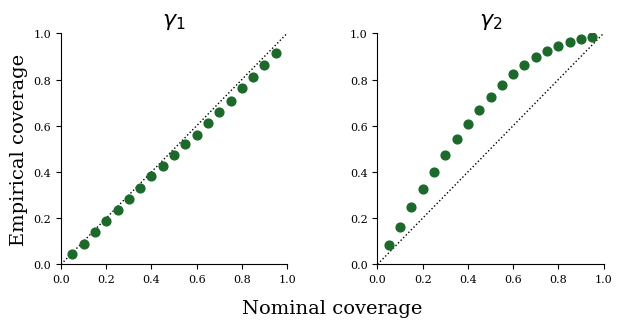

In [8]:
plot_coverage_probs(
    confidence_levels, shear1_coverage_probs, shear2_coverage_probs,
    save_path="figures/npe_coverageprobs_setting1.png"
)

**Plot 90% credible intervals**

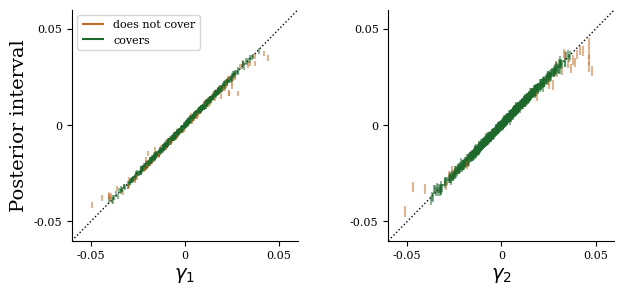

In [9]:
plot_credible_intervals(
    shear1_true, shear2_true,
    shear1_ci_lower, shear1_ci_upper,
    shear2_ci_lower, shear2_ci_upper,
    save_path="figures/npe_credibleintervals_setting1.png"
)

### **Setting 2**

In [10]:
setting2 = torch.load("npe_credible_intervals_setting2.pt", weights_only=False)

confidence_levels = setting2["confidence_levels"]
shear1_true = setting2["shear1_true"]
shear2_true = setting2["shear2_true"]
shear1_ci_lower = setting2["shear1_ci_lower"]
shear1_ci_upper = setting2["shear1_ci_upper"]
shear2_ci_lower = setting2["shear2_ci_lower"]
shear2_ci_upper = setting2["shear2_ci_upper"]

shear1_coverage_probs = compute_coverage_probs(shear1_true, shear1_ci_lower, shear1_ci_upper)
shear2_coverage_probs = compute_coverage_probs(shear2_true, shear2_ci_lower, shear2_ci_upper)

for i, ci in enumerate(confidence_levels):
    print(
        f"Confidence level: {ci:.2f}, Shear 1: {shear1_coverage_probs[i]:.4f}, Shear 2: {shear2_coverage_probs[i]:.4f}"
    )

Confidence level: 0.05, Shear 1: 0.0633, Shear 2: 0.0647
Confidence level: 0.10, Shear 1: 0.1251, Shear 2: 0.1351
Confidence level: 0.15, Shear 1: 0.1827, Shear 2: 0.2016
Confidence level: 0.20, Shear 1: 0.2462, Shear 2: 0.2623
Confidence level: 0.25, Shear 1: 0.3070, Shear 2: 0.3263
Confidence level: 0.30, Shear 1: 0.3670, Shear 2: 0.3885
Confidence level: 0.35, Shear 1: 0.4211, Shear 2: 0.4499
Confidence level: 0.40, Shear 1: 0.4806, Shear 2: 0.5107
Confidence level: 0.45, Shear 1: 0.5351, Shear 2: 0.5719
Confidence level: 0.50, Shear 1: 0.5890, Shear 2: 0.6276
Confidence level: 0.55, Shear 1: 0.6441, Shear 2: 0.6819
Confidence level: 0.60, Shear 1: 0.6986, Shear 2: 0.7334
Confidence level: 0.65, Shear 1: 0.7510, Shear 2: 0.7784
Confidence level: 0.70, Shear 1: 0.7998, Shear 2: 0.8212
Confidence level: 0.75, Shear 1: 0.8400, Shear 2: 0.8655
Confidence level: 0.80, Shear 1: 0.8825, Shear 2: 0.9042
Confidence level: 0.85, Shear 1: 0.9177, Shear 2: 0.9348
Confidence level: 0.90, Shear 1

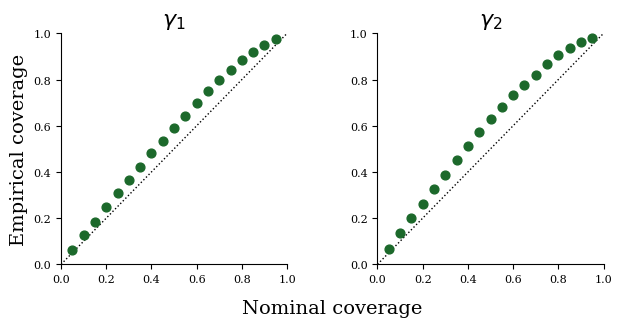

In [11]:
plot_coverage_probs(
    confidence_levels, shear1_coverage_probs, shear2_coverage_probs,
    save_path="figures/npe_coverageprobs_setting2.png"
)

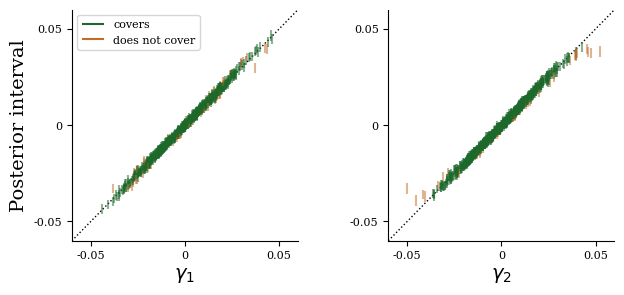

In [12]:
plot_credible_intervals(
    shear1_true, shear2_true,
    shear1_ci_lower, shear1_ci_upper,
    shear2_ci_lower, shear2_ci_upper,
    save_path="figures/npe_credibleintervals_setting2.png"
)

### **Setting 3**

In [13]:
setting3 = torch.load("npe_credible_intervals_setting3.pt", weights_only=False)

confidence_levels = setting3["confidence_levels"]
shear1_true = setting3["shear1_true"]
shear2_true = setting3["shear2_true"]
shear1_ci_lower = setting3["shear1_ci_lower"]
shear1_ci_upper = setting3["shear1_ci_upper"]
shear2_ci_lower = setting3["shear2_ci_lower"]
shear2_ci_upper = setting3["shear2_ci_upper"]

shear1_coverage_probs = compute_coverage_probs(shear1_true, shear1_ci_lower, shear1_ci_upper)
shear2_coverage_probs = compute_coverage_probs(shear2_true, shear2_ci_lower, shear2_ci_upper)

for i, ci in enumerate(confidence_levels):
    print(
        f"Confidence level: {ci:.2f}, Shear 1: {shear1_coverage_probs[i]:.4f}, Shear 2: {shear2_coverage_probs[i]:.4f}"
    )

Confidence level: 0.05, Shear 1: 0.0446, Shear 2: 0.0573
Confidence level: 0.10, Shear 1: 0.0911, Shear 2: 0.1114
Confidence level: 0.15, Shear 1: 0.1361, Shear 2: 0.1661
Confidence level: 0.20, Shear 1: 0.1848, Shear 2: 0.2226
Confidence level: 0.25, Shear 1: 0.2299, Shear 2: 0.2761
Confidence level: 0.30, Shear 1: 0.2767, Shear 2: 0.3301
Confidence level: 0.35, Shear 1: 0.3236, Shear 2: 0.3886
Confidence level: 0.40, Shear 1: 0.3725, Shear 2: 0.4431
Confidence level: 0.45, Shear 1: 0.4216, Shear 2: 0.4916
Confidence level: 0.50, Shear 1: 0.4700, Shear 2: 0.5429
Confidence level: 0.55, Shear 1: 0.5165, Shear 2: 0.5972
Confidence level: 0.60, Shear 1: 0.5653, Shear 2: 0.6472
Confidence level: 0.65, Shear 1: 0.6111, Shear 2: 0.6945
Confidence level: 0.70, Shear 1: 0.6596, Shear 2: 0.7428
Confidence level: 0.75, Shear 1: 0.7079, Shear 2: 0.7937
Confidence level: 0.80, Shear 1: 0.7591, Shear 2: 0.8366
Confidence level: 0.85, Shear 1: 0.8123, Shear 2: 0.8760
Confidence level: 0.90, Shear 1

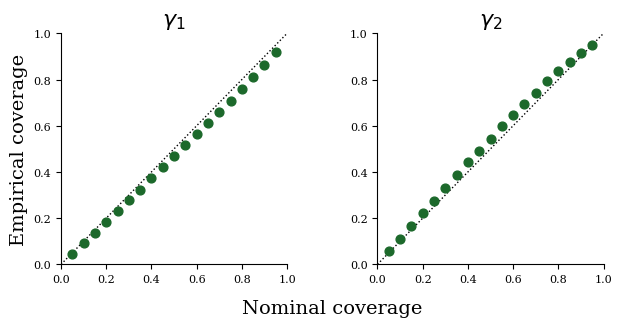

In [14]:
plot_coverage_probs(
    confidence_levels, shear1_coverage_probs, shear2_coverage_probs,
    save_path="figures/npe_coverageprobs_setting3.png"
)

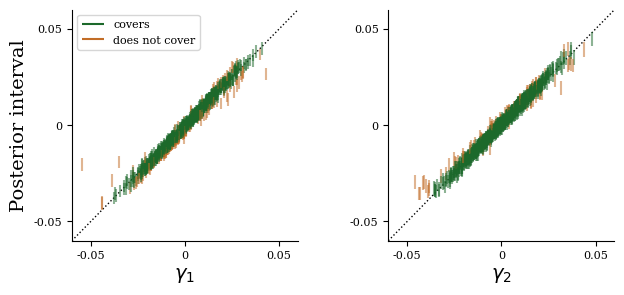

In [15]:
plot_credible_intervals(
    shear1_true, shear2_true,
    shear1_ci_lower, shear1_ci_upper,
    shear2_ci_lower, shear2_ci_upper,
    save_path="figures/npe_credibleintervals_setting3.png"
)

### **Setting 4**

In [16]:
setting4 = torch.load("npe_credible_intervals_setting4.pt", weights_only=False)

confidence_levels = setting4["confidence_levels"]
shear1_true = setting4["shear1_true"]
shear2_true = setting4["shear2_true"]
shear1_ci_lower = setting4["shear1_ci_lower"]
shear1_ci_upper = setting4["shear1_ci_upper"]
shear2_ci_lower = setting4["shear2_ci_lower"]
shear2_ci_upper = setting4["shear2_ci_upper"]

shear1_coverage_probs = compute_coverage_probs(shear1_true, shear1_ci_lower, shear1_ci_upper)
shear2_coverage_probs = compute_coverage_probs(shear2_true, shear2_ci_lower, shear2_ci_upper)

for i, ci in enumerate(confidence_levels):
    print(
        f"Confidence level: {ci:.2f}, Shear 1: {shear1_coverage_probs[i]:.4f}, Shear 2: {shear2_coverage_probs[i]:.4f}"
    )

Confidence level: 0.05, Shear 1: 0.0458, Shear 2: 0.0547
Confidence level: 0.10, Shear 1: 0.0878, Shear 2: 0.1109
Confidence level: 0.15, Shear 1: 0.1312, Shear 2: 0.1690
Confidence level: 0.20, Shear 1: 0.1748, Shear 2: 0.2256
Confidence level: 0.25, Shear 1: 0.2161, Shear 2: 0.2824
Confidence level: 0.30, Shear 1: 0.2630, Shear 2: 0.3341
Confidence level: 0.35, Shear 1: 0.3074, Shear 2: 0.3902
Confidence level: 0.40, Shear 1: 0.3476, Shear 2: 0.4384
Confidence level: 0.45, Shear 1: 0.3931, Shear 2: 0.4902
Confidence level: 0.50, Shear 1: 0.4380, Shear 2: 0.5432
Confidence level: 0.55, Shear 1: 0.4841, Shear 2: 0.5944
Confidence level: 0.60, Shear 1: 0.5248, Shear 2: 0.6440
Confidence level: 0.65, Shear 1: 0.5707, Shear 2: 0.6967
Confidence level: 0.70, Shear 1: 0.6162, Shear 2: 0.7457
Confidence level: 0.75, Shear 1: 0.6633, Shear 2: 0.7916
Confidence level: 0.80, Shear 1: 0.7120, Shear 2: 0.8333
Confidence level: 0.85, Shear 1: 0.7615, Shear 2: 0.8722
Confidence level: 0.90, Shear 1

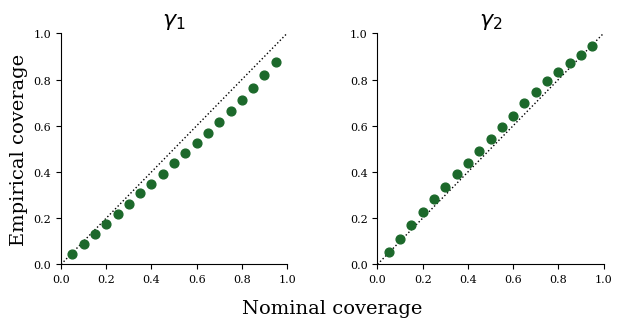

In [17]:
plot_coverage_probs(
    confidence_levels, shear1_coverage_probs, shear2_coverage_probs,
    save_path="figures/npe_coverageprobs_setting4.png"
)

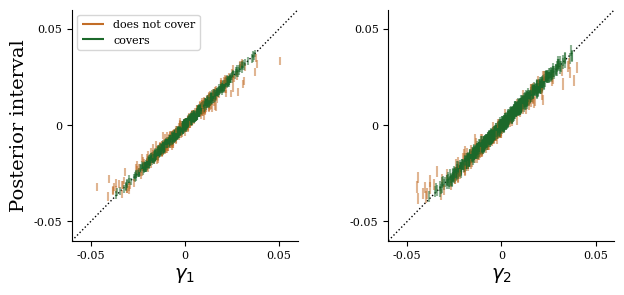

In [18]:
plot_credible_intervals(
    shear1_true, shear2_true,
    shear1_ci_lower, shear1_ci_upper,
    shear2_ci_lower, shear2_ci_upper,
    save_path="figures/npe_credibleintervals_setting4.png"
)

### **Setting 5**

In [19]:
setting5 = torch.load("npe_credible_intervals_setting5.pt", weights_only=False)

confidence_levels = setting5["confidence_levels"]
shear1_true = setting5["shear1_true"]
shear2_true = setting5["shear2_true"]
shear1_ci_lower = setting5["shear1_ci_lower"]
shear1_ci_upper = setting5["shear1_ci_upper"]
shear2_ci_lower = setting5["shear2_ci_lower"]
shear2_ci_upper = setting5["shear2_ci_upper"]

shear1_coverage_probs = compute_coverage_probs(shear1_true, shear1_ci_lower, shear1_ci_upper)
shear2_coverage_probs = compute_coverage_probs(shear2_true, shear2_ci_lower, shear2_ci_upper)

for i, ci in enumerate(confidence_levels):
    print(
        f"Confidence level: {ci:.2f}, Shear 1: {shear1_coverage_probs[i]:.4f}, Shear 2: {shear2_coverage_probs[i]:.4f}"
    )

Confidence level: 0.05, Shear 1: 0.0579, Shear 2: 0.0534
Confidence level: 0.10, Shear 1: 0.1132, Shear 2: 0.1003
Confidence level: 0.15, Shear 1: 0.1690, Shear 2: 0.1490
Confidence level: 0.20, Shear 1: 0.2234, Shear 2: 0.1986
Confidence level: 0.25, Shear 1: 0.2767, Shear 2: 0.2492
Confidence level: 0.30, Shear 1: 0.3325, Shear 2: 0.2969
Confidence level: 0.35, Shear 1: 0.3856, Shear 2: 0.3459
Confidence level: 0.40, Shear 1: 0.4364, Shear 2: 0.3904
Confidence level: 0.45, Shear 1: 0.4942, Shear 2: 0.4415
Confidence level: 0.50, Shear 1: 0.5457, Shear 2: 0.4886
Confidence level: 0.55, Shear 1: 0.5980, Shear 2: 0.5373
Confidence level: 0.60, Shear 1: 0.6456, Shear 2: 0.5863
Confidence level: 0.65, Shear 1: 0.6917, Shear 2: 0.6309
Confidence level: 0.70, Shear 1: 0.7369, Shear 2: 0.6748
Confidence level: 0.75, Shear 1: 0.7780, Shear 2: 0.7192
Confidence level: 0.80, Shear 1: 0.8189, Shear 2: 0.7637
Confidence level: 0.85, Shear 1: 0.8537, Shear 2: 0.8077
Confidence level: 0.90, Shear 1

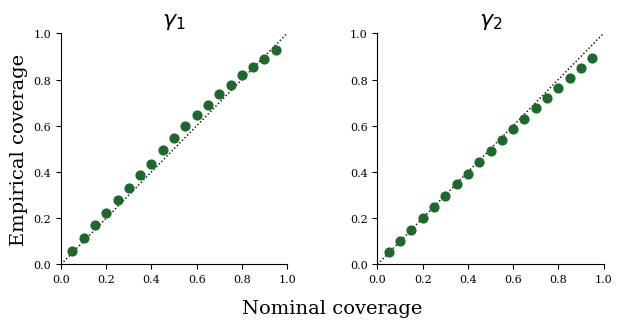

In [20]:
plot_coverage_probs(
    confidence_levels, shear1_coverage_probs, shear2_coverage_probs,
    save_path="figures/npe_coverageprobs_setting5.png"
)

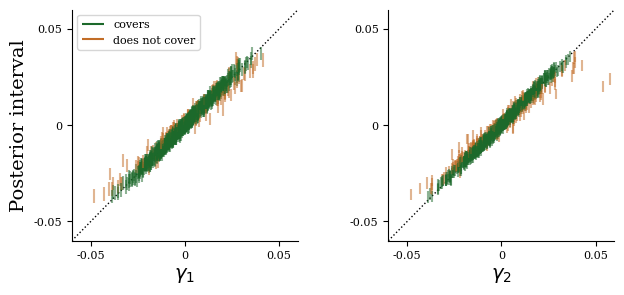

In [21]:
plot_credible_intervals(
    shear1_true, shear2_true,
    shear1_ci_lower, shear1_ci_upper,
    shear2_ci_lower, shear2_ci_upper,
    save_path="figures/npe_credibleintervals_setting5.png"
)